# Analysis of Real Estate Sales in King County, Washington

## Overview

We were tasked with creating a predictive model for home prices in King County, Washington. We elected to focus our model on predicting prices with the goal of helping families that earn roughly the median income for a household in Seattle (~100,000 dollars per year) buy a home that is in their price range and in an area with good schools. We used housing sale data from the King County House Sales dataset, student test score data from Washington State's open data portal, and school address information from the Washington School directory to build our model. We tried a variety of approaches in building our model, and using the strongest of these (r-squared of .71) we created predicted home sale prices for the dataset and compared those predictions to actual sale prices to determine in which zip codes homes are selling for less than we expect, and in which zip codes schools are better than average. Based on these factors, we recommend that families look to purchase housing in the 98004 zip code, which is in Bellevue, WA (10 minutes outside of Seattle by car).

## Business Problem

The Agrawal-Gerber Realty Firm assists families moving to King County, Washington in finding a market-rate home in an area with good schools for their kids. To inform our recommendations, we have created a model to predict the price of homes in King County (which comprises Seattle, Bellevue, Kent, and several other small- to mid-sized cities and towns). Housing in King County is very expensive (the median home in the dataset of sales county sold for 860,000 dollars), so families need to know that their investment represents a good value before they commit to buying a home.

By measuring our predictions against records of actual home sales from 2021 to 2022, we can recommend areas where we believe homes are selling for less than their true value - thus providing families with the ability to buy a home at a good price before the housing market catches up.

## Data Understanding

We used information from three datasets to build our model, all of which are saved in the data folder of our repository:
- Housing sale data from the King County House Sales dataset, which includes the target variable for our models (price) and a wide range of continuous, discrete, and categorical predictor variables, such as zip code, square feet of living space, and more.
- Student test score data from Washington State's open data portal, which we used to build a composite measure of average school quality by zip code to use as a predictor for our model.
- School address information from the Washington School directory to build our model, which we used to match schools to zip codes in the King County House Sales dataset.

To begin, we have to import the necessary libraries for our analysis and the King County House Sales dataset.

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import markdown

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats 

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# SKLearn Modules
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable
pd.options.display.max_columns = None
pd.options.display.width = None

In [2]:
hd = pd.read_csv("data/kc_house_data.csv")
f = open('data/column_names.md', 'r')
desc=markdown.markdown( f.read() )
hd.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591


Let's examine some of the basic properties of our dataset.

In [3]:
# check column names
hd.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [4]:
# check data types
hd.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
greenbelt         object
nuisance          object
view              object
condition         object
grade             object
heat_source       object
sewer_system      object
sqft_above         int64
sqft_basement      int64
sqft_garage        int64
sqft_patio         int64
yr_built           int64
yr_renovated       int64
address           object
lat              float64
long             float64
dtype: object

Some of these columns, such as view, condition, and grade, seem to be ordinal numerical columns, but are not currently stored as the type of variable we will ultimately want them to be to include them in our analysis. Others, such as waterfront, greenbelt, and nuisance, may be good candidates for one-hot encoding. We can dig into these further when we begin processing our data.

In [5]:
# describe the characteristics of the continuous variables in the dataset
hd.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


From this initial examination it seems like there may be at least a few data imputation errors - it's unlikely that there is a home with only 3 square feet of living space, for example. We'll need to make sure to deal with those issues before beginning to build our model. We should also check for null values.

In [6]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

Fortunately, there are very few null values in our dataset - only 32 in heat_source, and 14 in sewer_system. We can wait until we begin to process our data to deal with those.

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

Let's start by dealing with the row for the home that is only 3 square feet.

In [7]:
hd[hd['sqft_living'] <= 100]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
14977,1549500215,12/17/2021,1803000.0,4,4.0,3,326701,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PRIVATE,2,1,1,0,2021,0,"31072 Northeast 165th Street, Duvall, Washingt...",47.745290,-121.92362
28816,2923099027,12/13/2021,205000.0,1,0.0,100,25400,1.0,YES,NO,YES,AVERAGE,Fair,1 Cabin,NaN,NaN,100,0,0,140,1963,0,"49622 172nd Street Southeast, North Bend, Wash...",47.444745,-121.67879


There are two listings for homes in the dataset that are 100 square feet or smaller. The second of these is an oddity but there aren't enough issues to suggest it is included incorrectly in the dataset, whereas the first one is almost certainly an incorrect listing. Let's remove it.

In [8]:
hd.drop(index = 14977, axis = 0, inplace = True)

In building our model, we'll also want to exclude sale listings for homes with no bedrooms or no bathrooms. Our stakeholder (families moving to the area) are not interested in building a home on an empty lot, or making major renovations to prepare it for them to live in - they need a house that's ready for them (even if it's in need of some other work).

In [9]:
# find and drop sales records with no bedrooms or no bathrooms
nobed_nobath = hd.loc[(hd['bedrooms'] == 0) | (hd['bathrooms'] == 0)]
hd.drop(index = nobed_nobath.index, inplace = True, axis = 0)

We'll also want to add a few columns with basic information that isn't already included in the dataset, such as zip code and age of the house.

In [10]:
# add zip column for zipcodes
hd["zip"] = hd['address'].str[-20:-15].astype(int)

# add column for years old and sale year
hd["years_old"] = 2023 - hd["yr_built"]
hd["sale_year"] = hd['date'].str[-4:].astype(int)

Now that we have zip codes for each listing, we'll need to confirm that the dataset includes only homes in King County. To do so, we can create a list of zip codes using the [King County GIS Open Data portal](https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?filters=eyJDT1VOVFlfTkFNRSI6WyJLaW5nIENvdW50eSJdfQ%3D%3D&location=47.503077%2C-121.485100%2C8.71&showTable=true) and compare the zip codes for our records to that list to remove any that aren't in the county.

In [11]:
# create a list of King County zip codes
kingcounty_zips=[98001,98002,98003,98004,98005,98006,98007,98008,
                 98010,98011,98014,98019,98021,98022,98023,98024,
                 98027,98028,98029,98030,98031,98032,98033,98034,
                 98038,98039,98040,98042,98045,98047,98050,98051,
                 98052,98053,98055,98056,98057,98058,98059,98065,
                 98068,98070,98072,98074,98075,98077,98092,98101,
                 98102,98103,98104,98105,98106,98107,98108,98109,
                 98112,98115,98116,98117,98118,98119,98121,98122,
                 98125,98126,98133,98134,98136,98144,98146,98148,
                 98154,98155,98158,98164,98166,98168,98177,98178,
                 98188,98195,98198,98199,98224,98354,98422]

# find rows that have zip codes outside of King County
non_kc_zips = hd.loc[~hd["zip"].isin(kingcounty_zips)]
non_kc_zips.shape

(959, 28)

It looks like 959 of our records are from places other than King County. Let's remove them from our dataset.

In [12]:
# drop rows with zips that are not in King County
hd.drop(index = non_kc_zips.index, inplace = True, axis = 0)
hd

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,54,2022
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133,73,2021
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178,67,2021
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118,13,2021
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027,11,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940,98103,102,2021
30151,194000695,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851,98116,12,2021
30152,7960100080,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585,98122,28,2022
30153,2781280080,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,NONE,Average,8 Good,Gas,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908,98055,17,2022


Let's do a quick check for duplicate values in the 'id' column, since that should be a unique identifier for each listing.

In [13]:
# check to see if there's any values greater than 1
hd['id'].value_counts()

1233100736    2
6632900607    1
3678900411    1
5437810310    1
7852180850    1
             ..
2251500240    1
5253300275    1
5149300370    1
1972202200    1
9430110210    1
Name: id, Length: 29144, dtype: int64

Looks like there's one duplicate listing - let's double check, and if it is a duplicate let's remove it.

In [14]:
# check information for rows with duplicate id values
hd[hd['id'] == 1233100736]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year
4845,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PUBLIC,2590,1410,500,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,98033,4,2021
4846,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PUBLIC,2590,1410,500,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,98033,4,2021


Those listings are identical, so this is almost certainly an accidental duplicate. Let's remove it.

In [15]:
# remove the duplicate based on id
hd = hd.drop_duplicates(subset=["id"])

# check that it's gone 
hd[hd['id'] == 1233100736]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year
4845,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PUBLIC,2590,1410,500,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,98033,4,2021


Now that we've done some basic cleaning and feature additions, let's take another look at the description for our data.

In [16]:
hd.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zip,years_old,sale_year
count,2.914400e+04,2.914400e+04,29144.000000,29144.000000,29144.000000,2.914400e+04,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000,29144.000000
mean,4.535657e+09,1.112903e+06,3.441017,2.335506,2132.796974,1.711110e+04,1.516110,1827.234559,481.547488,336.970972,216.548003,1973.842232,93.527724,47.542959,-122.214876,98077.313684,49.157768,2021.361344
std,2.882395e+09,8.928455e+05,0.970070,0.892642,975.878972,6.059726e+04,0.547403,880.042425,586.098105,286.118703,246.597334,31.657073,422.109515,0.146098,0.141526,54.482404,31.657073,0.480398
min,1.000055e+06,2.736000e+04,1.000000,0.500000,290.000000,4.020000e+02,1.000000,290.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.159700,-122.526650,98001.000000,1.000000,2021.000000
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.429599,-122.328283,98032.000000,22.000000,2021.000000
50%,3.869900e+09,8.686500e+05,3.000000,2.500000,1950.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,142.000000,1976.000000,0.000000,47.557428,-122.234287,98059.000000,47.000000,2021.000000
75%,7.286500e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.077300e+04,2.000000,2290.000000,960.000000,520.000000,310.000000,2001.000000,0.000000,47.671695,-122.128011,98117.000000,71.000000,2022.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.789830,-121.417590,98422.000000,123.000000,2022.000000


There are still a wide range of housing types in our dataset, from homes with one bedroom that are only a few hundred feet, to mega-mansions with 13 bedrooms and over 15,000 square feet of space. While we will want to eventually hone in on the target market for our clients, it will be useful to build our model on the largest dataset we can to ensure our price predictions are as accurate as possible. With this initial step done, we can build a baseline model using simple linear regression and iterate from there.

## Baseline Model Construction

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

To build our baseline model, we'll want to build a simple linear regression model that uses the most strongly-correlated variable with price to make a prediction. Let's take a look at those correlations.

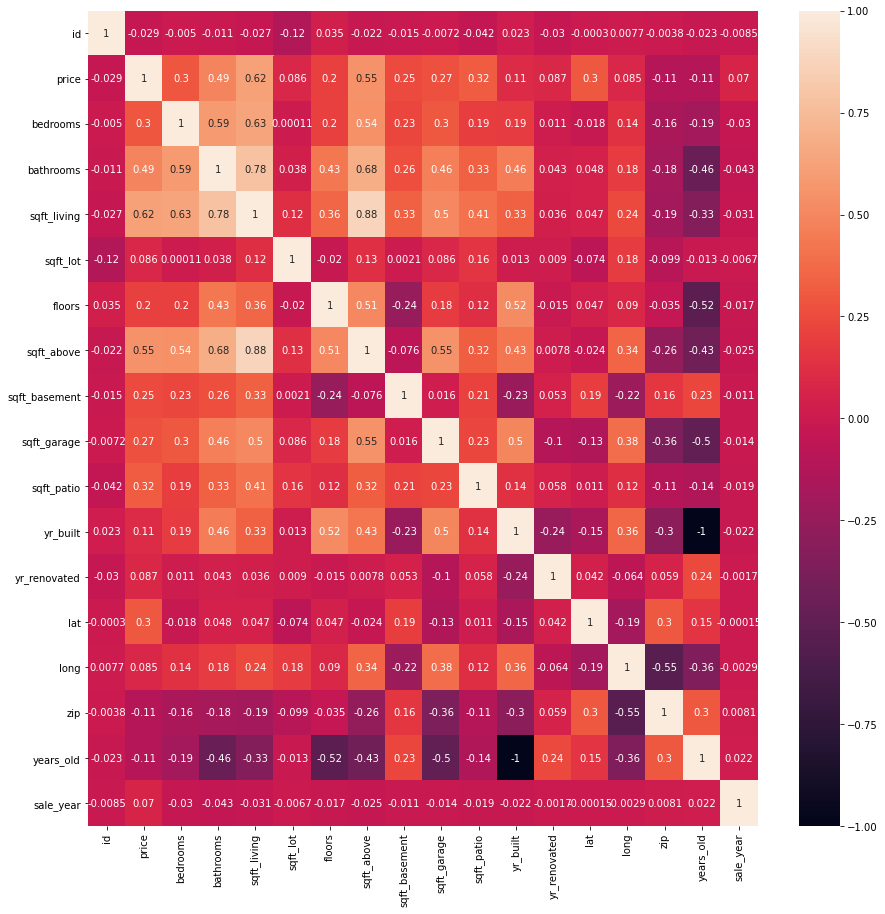

In [17]:
# plot the heatmap to determine correlations
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(hd.corr(), annot=True);

In [18]:
# list correlations in descending order
hd.corr()['price'].map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.620009
sqft_above       0.548946
bathrooms        0.491244
sqft_patio       0.319096
lat              0.299761
bedrooms         0.295065
sqft_garage      0.268733
sqft_basement    0.247070
floors           0.201760
years_old        0.106791
yr_built         0.106791
zip              0.105028
yr_renovated     0.086678
sqft_lot         0.085561
long             0.085443
sale_year        0.070175
id               0.029373
Name: price, dtype: float64

It looks like 'sqft_living,' or square footage of living space in the home, is the most strongly correlated predictor for price. What does that relationship look like?

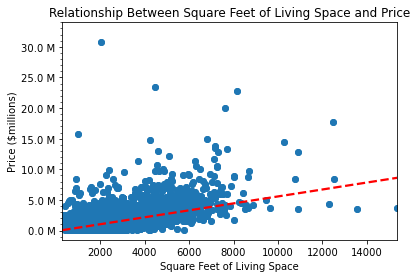

In [19]:
# create plot of square feet of living space vs price
fig, ax = plt.subplots()

plt.scatter(x=hd["sqft_living"], y=hd["price"])
sns.regplot(data = hd, x = 'sqft_living', y = 'price', line_kws={'ls':'--', 'color': 'r'}, ci = None)
ax.set_xlabel('Square Feet of Living Space')
ax.set_ylabel('Price ($millions)')
ax.set_title('Relationship Between Square Feet of Living Space and Price')

# format y axis to show values in millions
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

ax.set_yticks(range(-1000000, 35000000, 1000000), minor = True)
ax.yaxis.set_major_formatter(million_formatter);

In general, it looks like there is a positive relationship between living space and price. Let's see how the model performs.

In [20]:
# define variables for simple linear regression
y = hd['price']
X = hd.drop('price', axis = 1)

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# double check train-test split 
print(f"X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train has {y_train.shape[0]} rows")

X_train has 21858 rows and 27 columns
y_train has 21858 rows


In [21]:
# select our best correlated predictor, as our X Train
baseline_X_train = X_train[['sqft_living']]

# fit our model and show summary
baseline_train_model = sm.OLS(y_train, sm.add_constant(baseline_X_train)).fit()

# find mean absolute error
baseline_mae = baseline_train_model.resid.abs().sum() / len(y)

# print summary of model performance
baseline_train_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 1.582e+04
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:48:59   Log-Likelihood:            -3.2359e+05
No. Observations:               21858   AIC:                         6.472e+05
Df Residuals:                   21856   BIC:                         6.472e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.619e+04   1.05e+04     -8.202      0.000   -1.07e+05   -6.56e+04
sqft_living   561.8488      4.467    125.766      0.000     553.092     570.605
==============================================================================
Omnibus:                    20171.308   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1844685.954
Skew:                           4.145   Prob(JB):                         0.00
Kurtosis:                      47.235   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# print key results for interpretation
print(f"The R-squared value for our baseline model is {baseline_train_model.rsquared:.3f}.")
print(f"The mean absolute error for our baseline model is {baseline_mae:.2f} dollars.")

The R-squared value for our baseline model is 0.420.
The mean absolute error for our baseline model is 297474.79 dollars.


## Baseline Model Evaluation

Unsurprisingly, this initial model does not perform very well. It has an r-squared of only .420, meaning only 42 percent of the variance in price is explained by square feet of living area. Further, it has a mean absolute error of over 290,000 dollars, meaning for any given prediction our model is likely to be off from the true value by that amount. We will need to add more information to our model to improve its accuracy.

## Model 2: Adding More Predictor Variables

For our second model, we want to use more information from the King County House Sales dataset, but we also want to add in information about school quality since that will be a core consideration for our clients in their buying decision. Let's start by importing that data and putting it in a usable format for our dataset.

### Importing and cleaning school quality data

In [23]:
# Import school data
rc = pd.read_csv("data/Report_Card_Assessment_Data_2021-22_School_Year.csv")
addresses=pd.read_csv("data/Washington_School_Directory_20230214.csv")

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
# look at report card data
rc.head(2)

,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationId,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,SchoolOrganizationId,CurrentSchoolType,StudentGroupType,StudentGroup,GradeLevel,TestAdministration,TestSubject,Suppression,Count of Students Expected to Test,Count of students expected to test including previously passed,CountMetStandard,PercentMetStandard,PercentLevel1,PercentLevel2,PercentLevel3,PercentLevel4,PercentMetTestedOnly,PercentNoScore,DataAsOf
0,2021-22,District,Grays Harbor,Capital Region ESD 113,100004.0,14005.0,Aberdeen School District,100010.0,NaN,District Total,NaN,NaN,FRL,Low-Income,04,SBAC,ELA,None,176.0,176.0,54.0,30.7%,0.460227,0.221591,0.198864,0.107955,0.310345,0.011364,9/7/2022
1,2021-22,District,Grays Harbor,Capital Region ESD 113,100004.0,14005.0,Aberdeen School District,100010.0,NaN,District Total,NaN,NaN,Gender,Female,04,SBAC,ELA,None,107.0,107.0,35.0,32.7%,0.420561,0.224299,0.196262,0.130841,0.336538,0.028037,9/7/2022


In [25]:
rc.columns

Index(['SchoolYear', 'OrganizationLevel', 'County', 'ESDName',
       'ESDOrganizationId', 'DistrictCode', 'DistrictName',
       'DistrictOrganizationId', 'SchoolCode', 'SchoolName',
       'SchoolOrganizationId', 'CurrentSchoolType', 'StudentGroupType',
       'StudentGroup', 'GradeLevel', 'TestAdministration', 'TestSubject',
       'Suppression', 'Count of Students Expected to Test',
       'Count of students expected to test including previously passed',
       'CountMetStandard', 'PercentMetStandard', 'PercentLevel1',
       'PercentLevel2', 'PercentLevel3', 'PercentLevel4',
       'PercentMetTestedOnly', 'PercentNoScore', 'DataAsOf'],
      dtype='object')

In [26]:
# look at school addresses
addresses.head(2)

,ESDCode,ESDName,LEACode,LEAName,SchoolCode,SchoolName,LowestGrade,HighestGrade,AddressLine1,AddressLine2,City,State,ZipCode,PrincipalName,Email,Phone,OrgCategoryList,AYPCode,GradeCategory
0,32801,Educational Service District 101,1109,Washtucna School District,3075,Washtucna Elementary/High School,PK,12,730 East Booth Avenue,NaN,Washtucna,Washington,99371-0688,Vance Wing,vwing@tucna.wednet.edu,509.646.3211,"Public School, Regular School",P,PK-12
1,32801,Educational Service District 101,1122,Benge School District,3142,Benge Elementary,K,6,2978 E. Benge-Winona Rd.,NaN,Benge,Washington,99105-0697,,NaN,NaN,"Public School, Regular School",P,Elementary School


In [27]:
addresses.columns

Index(['ESDCode', 'ESDName', 'LEACode', 'LEAName', 'SchoolCode', 'SchoolName',
       'LowestGrade', 'HighestGrade', 'AddressLine1', 'AddressLine2', 'City',
       'State', 'ZipCode', 'PrincipalName', 'Email', 'Phone',
       'OrgCategoryList', 'AYPCode', 'GradeCategory'],
      dtype='object')

Both of these data sets include school names, which will allow us to join the information we need from each into a new dataset that includes school performance information from 'rc' and school location information from 'addresses.' Our approach will be to first narrow this both data sets to only schools in King County, and then create a composite performance metric based on the 'PercentMetStandard' column from the 'rc' DataFrame.

In [28]:
# clean up Addresses dataframe
# extract zip codes
addresses["ZipCode"] = addresses["ZipCode"].apply(lambda x: x[:5])
addresses["ZipCode"] = addresses["ZipCode"].astype(int)

# remove non-King County schools
non_kc_addresses = addresses.loc[~addresses['ZipCode'].isin(kingcounty_zips)]
non_kc_zips = hd.loc[~hd["zip"].isin(kingcounty_zips)]
addresses.drop(index = non_kc_addresses.index, inplace = True, axis = 0)

# keep only necessary information
addresses=addresses[["SchoolName", "ZipCode"]]
addresses.head(2)

,SchoolName,ZipCode
803,Middle College High School,98125
804,Tops K-8 School,98102


In [29]:
# clean up Report Card dataframe
# keep only necessary columns
rc = rc[["OrganizationLevel", "County", "SchoolName", "GradeLevel", "TestSubject", "PercentMetStandard"]]

# drop extraneous rows
rc = rc[rc["County"] == "King"].drop(columns=["County"])
rc = rc[rc["OrganizationLevel"] == "School"].drop(columns=["OrganizationLevel"])
rc = rc[rc["GradeLevel"] == "All Grades"].drop(columns=["GradeLevel"])
rc.head(2)

,SchoolName,TestSubject,PercentMetStandard
14611,Interagency Programs,Science,13.6%
14612,Interagency Programs,Science,7.1%


In [30]:
# check dtypes for record card dataframe
rc.dtypes

SchoolName            object
TestSubject           object
PercentMetStandard    object
dtype: object

In [31]:
# clean and data under percent met standard column to cast as float
rc["PercentMetStandard"]=rc["PercentMetStandard"].replace("Suppressed: N<10", "0.0%")
rc["PercentMetStandard"]=rc["PercentMetStandard"].replace("No Students", "0.0%")
rc["PercentMetStandard"]=rc["PercentMetStandard"].apply(lambda x: x.strip("%"))
rc["PercentMetStandard"]=rc["PercentMetStandard"].apply(lambda x: x.strip(">"))
rc["PercentMetStandard"]=rc["PercentMetStandard"].apply(lambda x: x.strip("<"))
rc["PercentMetStandard"]=rc["PercentMetStandard"].astype(float)

# average test scores by school and create a ratings column
rc = rc.groupby(["SchoolName"]).aggregate({"PercentMetStandard":"mean"}).sort_values(by=["SchoolName"]).reset_index()
rc["rating"] = rc["PercentMetStandard"]/10

In [32]:
# join dataframes and remove excess columns
schools = rc.merge(addresses, left_on="SchoolName", right_on="SchoolName")
schools = schools[["SchoolName", "rating", "ZipCode"]]
schools["ZipCode"] = schools["ZipCode"].astype(int)

# create dictionary with zip codes and average school rating for that zip
schools_dict = dict(zip(schools.ZipCode, round(schools.rating, 1)))

# add ratings to the X_train dataframe using zips
X_train['avg_school_quality'] = X_train['zip'].map(schools_dict)

In [33]:
X_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year,avg_school_quality
27749,8864000080,4/13/2022,3,2.0,1370,6104,1.0,NO,NO,NO,NONE,Average,6 Low Average,Electricity,PUBLIC,1370,0,0,150,1944,0,"13527 37th Avenue South, Tukwila, Washington 9...",47.48159,-122.28698,98168,79,2022,0.0
23845,2126069036,8/23/2021,4,2.5,3340,54730,2.0,NO,NO,YES,NONE,Average,9 Better,Gas,PRIVATE,3340,0,720,0,1998,0,"13228 218th Avenue Northeast, Woodinville, Was...",47.71798,-122.04718,98077,25,2021,3.2


Excellent - now we've assigned each sale listing an average school quality based on its zip code.

### Processing categorical variables

Now that we have assigned each listing an average school quality rating based on its zip code, let's handle the rest of our categorical variables. Some are ordinal and will require ordinal encoding; others are boolean and will require one-hot encoding. We'll start with the ordinal variables.

In [34]:
# create dictionaries for assigning ordinal values to appropriate columns
scale_mapper1 = {"NONE":0, "FAIR": 1, "AVERAGE":2, "GOOD":3, "EXCELLENT":4}
X_train["view"] = X_train["view"].replace(scale_mapper1)

scale_mapper2 = {"Poor":0, "Fair": 1, "Average":2, "Good":3, "Very Good":4}
X_train["condition"] = X_train["condition"].replace(scale_mapper2)

scale_mapper3 = {"1 Cabin":1, "2 Substandard": 2, "3 Poor":3, "4 Low":4, "5 Fair":5, 
               "6 Low Average":6, "7 Average": 7, "8 Good":8, "9 Better":9, "10 Very Good":10,
               "11 Excellent": 11, "12 Luxury":12, "13 Mansion":13 }
X_train["grade"] = X_train["grade"].replace(scale_mapper3)

In [35]:
# sanity check 
X_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year,avg_school_quality
27749,8864000080,4/13/2022,3,2.0,1370,6104,1.0,NO,NO,NO,0,2,6,Electricity,PUBLIC,1370,0,0,150,1944,0,"13527 37th Avenue South, Tukwila, Washington 9...",47.48159,-122.28698,98168,79,2022,0.0
23845,2126069036,8/23/2021,4,2.5,3340,54730,2.0,NO,NO,YES,0,2,9,Gas,PRIVATE,3340,0,720,0,1998,0,"13228 218th Avenue Northeast, Woodinville, Was...",47.71798,-122.04718,98077,25,2021,3.2


Looks like that worked for the View, Condition, and Grade columns. Next, we'll process the "yr_renovated" column. From our data exploration at the beginning we can see that at least 75% of the listings in this dataset have a "0" in that column, implying they've never been renovated. It will probably be more useful to our analysis to alter the information we use from that column so that it is a boolean - 0 for "has never been renovated", 1 for "has been renovated."

In [36]:
X_train['yr_renovated'].value_counts()

0       20815
2021       55
2018       39
2006       33
2004       33
        ...  
1972        1
1962        1
1951        1
1930        1
1966        1
Name: yr_renovated, Length: 80, dtype: int64

In [37]:
# create a new column with a boolean value
X_train['renovated'] = np.where(X_train['yr_renovated'] > 0, 1, 0)

#drop the old column
X_train.drop('yr_renovated', axis = 1, inplace = True)
X_train['renovated'].value_counts()

0    20815
1     1043
Name: renovated, dtype: int64

The number of zeroes for each column lines up, so it looks like it worked properly. Now, let's one-hot encode each of the columns that has a boolean value - waterfront, greenbelt, nuisance, and renovated.

In [38]:
# one hot encoding categorical variables and dropping first column to avoid dummy variable trap
X_train = pd.get_dummies(X_train, columns = ['waterfront', 'greenbelt', 'nuisance', 'renovated'], drop_first = True)
X_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,address,lat,long,zip,years_old,sale_year,avg_school_quality,waterfront_YES,greenbelt_YES,nuisance_YES,renovated_1
27749,8864000080,4/13/2022,3,2.0,1370,6104,1.0,0,2,6,Electricity,PUBLIC,1370,0,0,150,1944,"13527 37th Avenue South, Tukwila, Washington 9...",47.48159,-122.28698,98168,79,2022,0.0,0,0,0,0
23845,2126069036,8/23/2021,4,2.5,3340,54730,2.0,0,2,9,Gas,PRIVATE,3340,0,720,0,1998,"13228 218th Avenue Northeast, Woodinville, Was...",47.71798,-122.04718,98077,25,2021,3.2,0,0,1,0


Finally, let's drop some of the values that we won't be using in our analysis - id, date, heat source, sewer system, address, lat, long, and sale year (since our exploration also revealed that all sales occurred in either 2021 or 2022).

In [39]:
X_train.drop(columns=['id', 'date', "heat_source", "sewer_system", "address", "lat", "long"], inplace = True)

Let's examine our new training dataset to make sure there are no missing values before we proceed.

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21858 entries, 27749 to 24487
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            21858 non-null  int64  
 1   bathrooms           21858 non-null  float64
 2   sqft_living         21858 non-null  int64  
 3   sqft_lot            21858 non-null  int64  
 4   floors              21858 non-null  float64
 5   view                21858 non-null  int64  
 6   condition           21858 non-null  int64  
 7   grade               21858 non-null  int64  
 8   sqft_above          21858 non-null  int64  
 9   sqft_basement       21858 non-null  int64  
 10  sqft_garage         21858 non-null  int64  
 11  sqft_patio          21858 non-null  int64  
 12  yr_built            21858 non-null  int64  
 13  zip                 21858 non-null  int64  
 14  years_old           21858 non-null  int64  
 15  sale_year           21858 non-null  int64  
 16  

There are a small number of missing values in our average school quality column. We will impute the mean school quality for those missing values, since it represents a very small portion of our dataset and therefore will not have too significant of an impact on the variance of the data.

In [41]:
# impute mean average school quality for missing values
X_train.loc[X_train['avg_school_quality'].isna()] = X_train['avg_school_quality'].mean()

# check that it worked
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21858 entries, 27749 to 24487
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            21858 non-null  float64
 1   bathrooms           21858 non-null  float64
 2   sqft_living         21858 non-null  float64
 3   sqft_lot            21858 non-null  float64
 4   floors              21858 non-null  float64
 5   view                21858 non-null  float64
 6   condition           21858 non-null  float64
 7   grade               21858 non-null  float64
 8   sqft_above          21858 non-null  float64
 9   sqft_basement       21858 non-null  float64
 10  sqft_garage         21858 non-null  float64
 11  sqft_patio          21858 non-null  float64
 12  yr_built            21858 non-null  float64
 13  zip                 21858 non-null  float64
 14  years_old           21858 non-null  float64
 15  sale_year           21858 non-null  float64
 16  

### Running the all variable model

Now that we have a complete, clean dataset, let's run a multiple variable model and see how it performs in comparison to the baseline model.

In [47]:
# create a copy of our X_train for running the all variable model
all_variable_X = X_train.copy()

# instantiate and fit the all variable model
all_variable_model = sm.OLS(y_train, sm.add_constant(all_variable_X)).fit()

# find mean absolute error
all_variable_mae = all_variable_model.resid.abs().sum() / len(y)

all_variable_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     1414.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:51:16   Log-Likelihood:            -3.2015e+05
No. Observations:               21858   AIC:                         6.404e+05
Df Residuals:                   21836   BIC:                         6.405e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.702e+06   1.89e+05    -14.266      0.000   -3.07e+06   -2.33e+06
bedrooms           -9.054e+04   5350.431    -16.922      0.000   -1.01e+05   -8.01e+04
bathrooms           8.992e+04   7761.952     11.585      0.000    7.47e+04    1.05e+05
sqft_living          132.5942     17.563      7.550      0.000      98.170     167.019
sqft_lot              -0.1500      0.067     -2.246      0.025      -0.281      -0.019
floors             -1.006e+05   9849.841    -10.212      0.000    -1.2e+05   -8.13e+04
view                8.637e+04   5177.854     16.681      0.000    7.62e+04    9.65e+04
condition           3.156e+04   5961.126      5.295      0.000    1.99e+04    4.32e+04
grade               2.137e+05   5671.208     37.683      0.000    2.03e+05    2.25e+05
sqft_above           285.8573     17.800     16.059      0.000     250.967     320.747
sqft_basement        131.0199     13.197      9.928      0.000     105.153     156.887
sqft_garage         -166.9248     18.774     -8.891      0.000    -203.724    -130.126
sqft_patio            64.5433     17.388      3.712      0.000      30.462      98.624
yr_built           -1.586e+05   8794.135    -18.038      0.000   -1.76e+05   -1.41e+05
zip                 -145.4211     81.089     -1.793      0.073    -304.361      13.519
years_old          -1.552e+05   8814.942    -17.610      0.000   -1.73e+05   -1.38e+05
sale_year           1.663e+05   7834.328     21.229      0.000    1.51e+05    1.82e+05
avg_school_quality  9.532e+04   2376.716     40.108      0.000    9.07e+04       1e+05
waterfront_YES      7.397e+05   3.14e+04     23.525      0.000    6.78e+05    8.01e+05
greenbelt_YES        1.48e+04   2.41e+04      0.613      0.540   -3.25e+04    6.21e+04
nuisance_YES        4.023e+04   1.02e+04      3.933      0.000    2.02e+04    6.03e+04
renovated_1         5.548e+04    1.9e+04      2.917      0.004    1.82e+04    9.28e+04
==============================================================================
Omnibus:                    20180.635   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2252356.963
Skew:                           4.071   Prob(JB):                         0.00
Kurtosis:                      52.059   Cond. No.                     5.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# print key results for interpretation
print(f"The R-squared value for our all variable model is {all_variable_model.rsquared:.3f}.")
print(f"The mean absolute error for our all variable model is {all_variable_mae:.2f} dollars.")
print('\n')
print(f"The R-squared value for our baseline model is {baseline_train_model.rsquared:.3f}.")
print(f"The mean absolute error for our baseline model is {baseline_mae:.2f} dollars.")

The R-squared value for our all variable model is 0.576.
The mean absolute error for our all variable model is 248293.42 dollars.


The R-squared value for our baseline model is 0.420.
The mean absolute error for our baseline model is 297474.79 dollars.


## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [ ]:
# code here to arrive at a baseline prediction

### First  Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
